<a href="https://colab.research.google.com/github/opopiol/ML_project/blob/model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import io
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### **Neptune**

In [3]:
%pip install --upgrade --quiet neptune-client
#pip install neptune-notebooks

     |████████████████████████████████| 245kB 5.2MB/s 
     |████████████████████████████████| 829kB 10.1MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 174kB 18.8MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 133kB 18.2MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 


In [4]:
import neptune.new as neptune
#run = neptune.init(project='opopiol/ML-project')
run = neptune.init(project='opopiol/ML-project',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5YjIyYjU2ZS0wMTc5LTQ3NWUtOWZkZC05OTg2YzI1M2VkNDUifQ==') # your credentials

run["JIRA"] = "NPT-952"
run["parameters"] = {"learning_rate": 0.001,
                     "optimizer": "Adam"}

for epoch in range(100):
   run["train/loss"].log(epoch * 0.4)
run["eval/f1_score"] = 0.66

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/opopiol/ML-project/e/MLPROJ-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


###**Reducing DataFrame memory size**


In [5]:
#Reducing DataFrame memory size
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65?fbclid=IwAR3XPzjakD69RqAEKuAnTDUtfw3AeCAj19eyd6LfzVSwHHICNgxW-ptK-vs

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",props[col].dtype)
            #print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

### **Data import**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#import train dataset
train_path = '/content/drive/MyDrive/project/train_data.csv'
train_data = pd.read_csv(train_path, header=None)

In [8]:
train_data= reduce_mem_usage(train_data)

Memory usage of properties dataframe is : 286.1024169921875  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  143.05126953125  MB
This is  50.000021333324234 % of the initial size


In [9]:
#import labels
labels_path = '/content/drive/MyDrive/project/train_labels.csv'
labels = pd.read_csv(labels_path, header=None,  names=['y'])

In [10]:
labels= reduce_mem_usage(labels)

Memory usage of properties dataframe is : 0.0287322998046875  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.0036983489990234375  MB
This is  12.871747211895912 % of the initial size


In [11]:
#import test dataset
test_path = '/content/drive/MyDrive/project/test_data.csv'
test_data = pd.read_csv(test_path, header=None)

In [12]:
test_data= reduce_mem_usage(test_data)

Memory usage of properties dataframe is : 95.3675537109375  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  47.67668533325195  MB
This is  49.99256400951807 % of the initial size


In [13]:
X, y = train_data, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

### ***EDA***

In [14]:
y.value_counts()

y 
 1    3375
-1     375
dtype: int64

In [15]:
y = y['y'].apply(lambda x: 0 if x == -1 else 1)

In [16]:
y.value_counts()

1    3375
0     375
Name: y, dtype: int64

In [17]:
X_train.shape

(2625, 10000)

In [18]:
y_train.shape

(2625, 1)

In [19]:
#scaling data

#StandardScaler
scaler = StandardScaler()

X_train_scale = StandardScaler().fit_transform(X_train)
y_train_scale = scaler.fit_transform(y_train)

In [20]:
#MinMaxScaler
minmaxscaler = MinMaxScaler()
X_train_minmaxscaler = MinMaxScaler().fit_transform(X_train)

In [ ]:
X_train_scale.mean(axis=0)

#X_train_scale has now unit variance and zero mean

array([ 1.7438616e-08, -9.4459169e-09,  3.6330450e-09, ...,
        2.9064360e-09, -1.7438616e-08,  2.9064360e-09], dtype=float32)

In [21]:
y_train = y_train['y'].apply(lambda x: 0 if x == -1 else 1)

In [ ]:
#final_pca_df = pd.DataFrame(data = X_pca)
#final_pca = pd.concat([final_pca_df, y_train], axis = 1)
#final_pca

In [ ]:
sns.set_palette('Set1')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


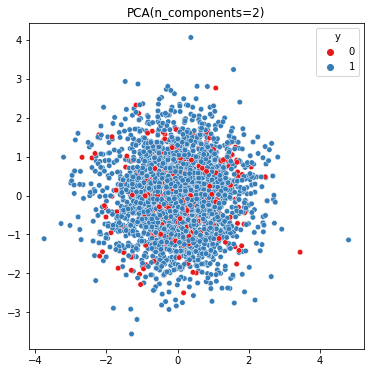

In [ ]:
#PCA

pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X_train_scale)

plt.figure(figsize=(6,6))
plt.title('PCA(n_components=2)')
sns.scatterplot(X_pca[:,0],
           X_pca[:,1], 
           s=30, hue=y_train);



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


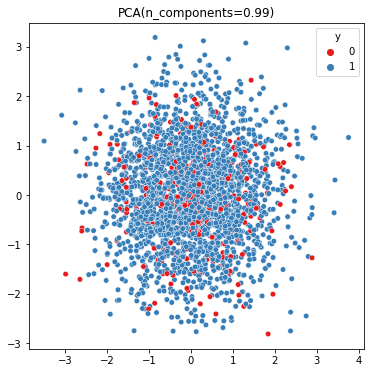

In [ ]:
#PCA

pca = PCA(n_components=0.99, whiten=True)
X_pca = pca.fit_transform(X_train_scale)

plt.figure(figsize=(6,6))
plt.title('PCA(n_components=0.99)')
sns.scatterplot(X_pca[:,0],
           X_pca[:,1], 
           s=30, hue=y_train);

In [ ]:
pca = PCA()
tsne = TSNE()

def clustering_scatterplot(a, b):
  """This function creates scatterplot with clusters from seaborn's library
    :param a: n_components for PCA
    :param b: n_components for TSNE
    :return: sns.scatterplot(X_p[:,0], X_p[:,1], c=y): scatterplot with clusters
    """
  pipeline = Pipeline([('pca', PCA(n_components = a)), ('tsne', TSNE(n_components = b))])
  X_p = pipeline.fit_transform(X)

  sns.scatterplot(X_p[:,0], X_p[:,1], c=y)
  plt.title(f'PCA(n_components={a})&TSNE(n_components={b})');

W ten sposób t-SNE mapuje dane wielowymiarowe do przestrzeni o niższych wymiarach i próbuje znaleźć wzorce w danych, identyfikując obserwowane klastry na podstawie podobieństwa punktów danych o wielu cechach. Jednak po tym procesie cechy wejściowe nie są już identyfikowalne i nie można wnioskować wyłącznie na podstawie danych wyjściowych t-SNE. Jest to więc głównie technika eksploracji i wizualizacji danych. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


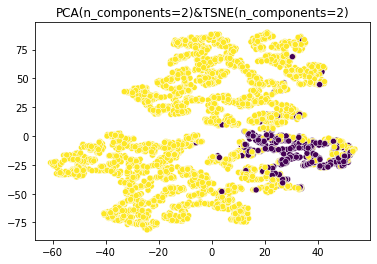

In [ ]:
clustering_scatterplot(2, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


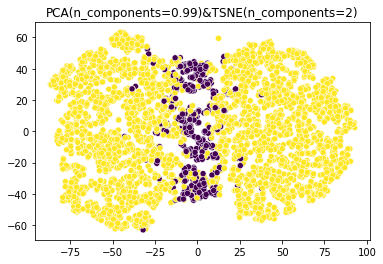

In [ ]:
#best for our project with n_components=0.99 for PCA and n_components=2 for TSNE
clustering_scatterplot(0.99, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


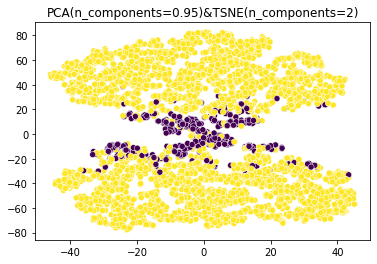

In [ ]:
clustering_scatterplot(0.95, 2)

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)), ('tsne', TSNE(n_components=2))])
X_p = pipeline.fit_transform(X)

sns.scatterplot(X_p[:,0],
           X_p[:,1], c=y);

KeyboardInterrupt: ignored

In [ ]:
pipeline = Pipeline([('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=0.99)), ('tsne', TSNE(n_components=2))])
X_p = pipeline.fit_transform(X)

sns.scatterplot(X_p[:,0],
           X_p[:,1], c=y);

### **MODEL**

In [22]:
def get_confusion_matrix(classifier):
    """This function returns a confusion matrix of given classifier
    :param classifier: classifier
    :return: print(confusion_matrix(y_test, y_pred)): confusion matrix of given classifier
    """
    m = classifier.fit(X, y)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    print(confusion_matrix(y_test, y_pred))

### **Baseline**

For stratified strategy score is 0.8133333333333334 with labels: [0 1]
[[  0  11 110]
 [  0   0   0]
 [  0  89 915]]
For most_frequent strategy score is 0.8924444444444445 with labels: [1]
[[   0  121]
 [   0 1004]]
For prior strategy score is 0.8924444444444445 with labels: [1]
[[   0  121]
 [   0 1004]]
For uniform strategy score is 0.4408888888888889 with labels: [0 1]
[[  0  74  47]
 [  0   0   0]
 [  0 503 501]]


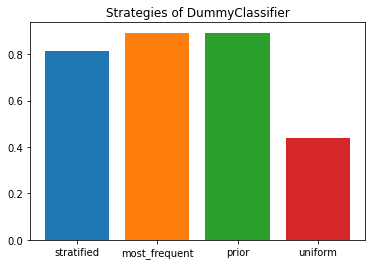

In [23]:
#baseline
strategies = ['stratified', 'most_frequent', 'prior', 'uniform']

def dummy_base(list):
  """This function returns scores and plot with scores of the given strategies of DummyClassifier
    :param list: list of strategies
    :return: print(f'For {i} strategy score is {dummy_clf_score} with labels: {dummy_labels}'): scores of the strategies given in the list and labels
    :return: plt.bar(i, dummy_clf_score): plot with scores of the strategies given in the list
    """
  for i in list:
      dummy_clf = DummyClassifier(strategy=i)
      dummy_clf.fit(X_train, y_train)
      y_pred = dummy_clf.predict(X_test)
      dummy_clf_score = accuracy_score(y_test, y_pred)
      dummy_labels = np.unique(dummy_clf.predict(X_test))
      print(f'For {i} strategy score is {dummy_clf_score} with labels: {dummy_labels}')
      get_confusion_matrix(dummy_clf)
      
      plt.title('Strategies of DummyClassifier')
      plt.bar(i, dummy_clf_score)
            
dummy_base(strategies)



In [24]:
def decisiontree_clf():
    """This function returns score of DecisionTreeClassifier
    :return: print(dtc_clf.__class__.__name__, dtc_clf_score): score of the classifier
    """
    dtc_clf = DecisionTreeClassifier().fit(X, y)
    dtc_clf.fit(X_train, y_train)
    y_pred = dtc_clf.predict(X_test)
    dtc_clf_score = accuracy_score(y_test, y_pred)
    print(dtc_clf.__class__.__name__, dtc_clf_score)
    get_confusion_matrix(dtc_clf)

decisiontree_clf()

DecisionTreeClassifier 0.8622222222222222
[[  0  87  34]
 [  0   0   0]
 [  0  29 975]]


LogisticRegression 0.7662222222222222
[[  0  18 103]
 [  0   0   0]
 [  0 142 862]]
KNeighborsClassifier 0.8782222222222222
[[  0  92  29]
 [  0   0   0]
 [  0  16 988]]
SVC 0.8702222222222222
[[  0  98  23]
 [  0   0   0]
 [  0  25 979]]


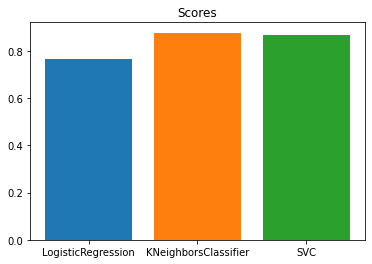

In [25]:
log_clf = LogisticRegression(random_state=0, max_iter = 1000)
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
#voting_clf = VotingClassifier()

clf_list = [log_clf, knn_clf, svm_clf]

def clf_scores(list):
  """This function returns scores and plot with scores of the classifiers given in the list
    :param list: list of classifiers
    :return: print(clf.__class__.__name__, accuracy_score(y_test, y_pred)): scores of the classifiers given in the list
    :return: plt.bar(clf.__class__.__name__, accuracy_score(y_test, y_pred)): plot with scores of the classifiers given in the list
    """
  for clf in list:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    clf_score = accuracy_score(y_test, y_pred)
    print(clf.__class__.__name__, clf_score)
    get_confusion_matrix(clf)

    plt.title('Scores')
    plt.bar(clf.__class__.__name__, clf_score);

clf_scores(clf_list)


In [56]:
#sns.swarmplot(data=X_train, y='clf', x='score')

In [57]:
def clf_scores_pca(classifier):
  """This function shows score of given calssiefier with chosen PCA(n_components=0.99) and StandardScaler
    :param classifier: classifier
    :return: print(classifier.__class__.__name__, accuracy_score(y_test, y_pred)): print name and score of chosen classiefier
    """
  pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)), ('classifier', classifier)])

  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  print(classifier.__class__.__name__, accuracy_score(y_test, y_pred))

In [58]:
clf_scores_pca(knn_clf)

KNeighborsClassifier 0.8977777777777778


In [ ]:
#RandomForestClassifier

rnf = RandomForestClassifier().fit(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#creating pipeline

pipe = Pipeline([('pca', pca), ('scaler', scaler), 
                ('classifier', SVC())
            ])


search_space = [{'scaler': [StandardScaler()],
                'pca': [PCA()]},
                {'classifier': [SVC()],
                 'classifier__kernel': ['linear', 'poly'],
                 'classifier__class_weight': [None, 'balanced'],
                 'classifier__gamma': ['scale', 'auto'],
                 'classifier__C': np.logspace(1,4,10)},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': [2, 4, 6, 8, 10, 20],
                 'classifier__algorithm': ['auto']}]

In [ ]:
grid_search = GridSearchCV(pipe,
                           search_space,
                           cv=5,
                           verbose=2,
                           n_jobs=-2,
                           scoring='balanced_accuracy')


In [ ]:
#best_model = grid_search.fit(X, y.values)

### **AdaBoostClassifier**

In [26]:
from sklearn.ensemble import AdaBoostClassifier

estimator = AdaBoostClassifier()
estimator.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [61]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
estimator_score = accuracy_score(y_test, y_pred)
print(estimator.__class__.__name__, estimator_score)

AdaBoostClassifier 0.8791111111111111


In [67]:
#choosing best model

print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X, y))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)
The mean accuracy of the model is: 0.49214814814814817


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [68]:
classifier = AdaBoostClassifier()
param = [{'n_estimators': [50, 100, 150],
         'learning_rate': [0.1, 0.01, 0.05]}]

grid_search = GridSearchCV(classifier,
                           param,
                           cv=3,
                           verbose=2,
                           n_jobs=-1,
                           scoring='balanced_accuracy')

In [69]:
best_model = grid_search.fit(X_test, y_test.values)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 27.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test, y_test))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)
The mean accuracy of the model is: 0.9179271708683474


In [77]:
test_data.shape

(1250, 10000)

In [27]:
a = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)

a.fit(X_train, y_train)
y_pred = a.predict(test_data)

#a_score = accuracy_score(y_test, y_pred)
#print(a.__class__.__name__, a_score)

ValueError: ignored

### **XGBClassifier**

In [29]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

classifier = XGBClassifier()
param = [{'n_estimators': [50, 100, 150],
         'learning_rate': [0.1, 0.01, 0.05],
          'max_depth': [5, 7, 9]}]

grid_search = GridSearchCV(classifier,
                           param,
                           cv=3,
                           verbose=2,
                           n_jobs=-1,
                           scoring='balanced_accuracy')

In [30]:
best_model = grid_search.fit(X_test, y_test.values)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 28.3min


KeyboardInterrupt: ignored

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt import Trials

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rnd_clsf = RandomizedSearchCV(classifier,
                           param,
                           cv=3,
                           verbose=2,
                           n_jobs=-2,
                           scoring='balanced_accuracy')

In [ ]:
https://blog.prokulski.science/2020/12/23/hyperopt-scikit-learn/

Pewnie nie muszę przypominać, że podczas poszukiwania parametrów, oceny klasyfikatora powinniśmy dokonywać na danych, które nie były wykorzystywane do treningu. W przeciwnym wypadku padamy ofiarą przeuczenia (ang. overfittingu), czyli dostosowania się algorytmu do naszego zbioru. Obliczony model będzie działał rewelacyjnie na danych treningowych, ale już na rzeczywistych będziemy osiągali słabe wyniki. Najłatwiej można poradzić sobie na dwa sposoby:

    Podzielić zbiór treningowy na dwie części, służącą do treningu (train dataset) oraz walidacyjną (validation dataset). Poszukiwanie parametrów uruchamiać na części treningowej a ocenę przeprowadzić na części walidacyjnej.

estimators = {'LogisticRegression': {'estimator': LogisticRegression(),
                                     'estimator__penalty':['l1', 'l2', 'elasticnet', 'none'],
                                     'estimator__class_weight': ['balanced'],
                                     'estimator__C': np.logspace(0, 4, 10000),
                                     'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              'LinearDiscriminantAnalysis': {'estimator': LinearDiscriminantAnalysis(),
                                             'estimator__solver': ['svd', 'lsqr', 'eigen']},
              'QuadraticDiscriminantAnalysis' :{'estimator': QuadraticDiscriminantAnalysis()},
              'GaussianNB': {'estimator': GaussianNB()},
              'BernoulliNB': {'estimator': BernoulliNB(),
                              'estimator__alpha': np.logspace(0,1,10, endpoint=False)/10},
              'DecisionTreeClassifier': {'estimator': DecisionTreeClassifier(),
                                         'estimator__criterion': ['gini', 'entropy'],
                                         'estimator__class_weight': ['balanced'],
                                         'estimator__splitter': ['best', 'random'],
                                         'estimator__max_depth': [2,5,10,None]},
              'SVC': {'estimator': SVC(),
                      'estimator__C': np.logspace(0, 4, 10000),
                      'estimator__class_weight': ['balanced'],
                      'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                      'estimator__gamma': ['scale', 'auto']},
              'LinearSVC': {'estimator': LinearSVC(),
                            'estimator__penalty': ['l1','l2'],
                            'estimator__loss': ['hinge', 'squared_hinge'],
                            'estimator__class_weight': ['balanced'],
                            'estimator__C': np.logspace(0, 4, 10000)},
              'NuSVC': {'estimator': NuSVC(),
                        'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                        'estimator__gamma': ['scale', 'auto'],
                        'estimator__class_weight': ['balanced']},
              'OneClassSVM': {'estimator': OneClassSVM(),
                              'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                              'estimator__gamma': ['scale', 'auto'],
                              'estimator__class_weight': ['balanced']},
              'RandomForestClassifier': {'estimator': RandomForestClassifier(),
                                         'estimator__n_estimators': [10,20,50,100,200,500,1000],
                                         'estimator__criterion': ['gini', 'entropy'],
                                         'estimator__max_depth': [2,5,10,None],
                                         'estimator__max_features': ['auto', 'sqrt', 'log2'],
                                         'estimator__class_weight': ['balanced', 'balanced_subsample']},
              'IsolationForest': {'estimator': IsolationForest(),
                                  'estimator__n_estimators': [10,20,50,100,200,500,1000]},
              'GradientBoostingClassifier': {'estimator': GradientBoostingClassifier(),
                                             'estimator__n_estimators': [10,20,50,100,200,500,1000],
                                             'estimator__learning_rate': np.logspace(0,1,10, endpoint=False)/10,
                                             'estimator__criterion': ['friedman_mse', 'mse', 'mae'],
                                             'estimator__max_features': ['auto', 'sqrt', 'log2']}
             }